In [1]:
#!pip3 install tensorflow==2.3.0
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
import os, cv2
import random
import scipy

2.4.0
2.4.0


In [2]:
train_data = '/content/drive/MyDrive/Brain Cancer/Train Data'

def read_image(im_path):
  img = cv2.imread(im_path,0)
  img = cv2.resize(img,(240,240))
  return img

x_train, y_train = [],[]
list_folder=os.listdir(path = train_data)
encoder = OneHotEncoder()
for i in list_folder:
  new_path = os.path.join(train_data,i) 
  pic_list = os.listdir(new_path)                                         
  for img in pic_list:  
    im_path = os.path.join(new_path,img)
    image = read_image(im_path)
    if i == 'flair':
      label = 0
    elif i == 't1':
      label = 1
    elif i == 't1ce':
      label = 2
    elif i == 't2':
      label = 3
    x_train.append(image) 
    y_train.append(label)

X_train = np.array(x_train).reshape(-1,240,240,1)
X_train = X_train/255
y_train = np.array(y_train).reshape(-1,1)
y_train = encoder.fit_transform(y_train)
Y_train = y_train.toarray()
print("Train images reading is done")
print("Number of Train images",X_train.shape[0])

test_data = '/content/drive/MyDrive/Brain Cancer/Test Data for RPi'
x_test, y_test = [], []
list_folder=os.listdir(path = test_data)
for i in list_folder:
  new_path=os.path.join(test_data,i) 
  pic_list=os.listdir(new_path)                                              
  for img in pic_list:  
    im_path = os.path.join(new_path,img)
    image = read_image(im_path)
    if i == 'flair':
      label = 0
    elif i == 't1':
      label = 1
    elif i == 't1ce':
      label = 2
    elif i == 't2':
      label = 3
    x_test.append(image) 
    y_test.append(label) 

print("Test images reading is done")
X_test = np.array(x_test).reshape(-1,240,240,1)
X_test = X_test/255
y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)
Y_test = y_test.toarray()
print("Number of Test images",X_test.shape[0])

Train images reading is done
Number of Train images 769
Test images reading is done
Number of Test images 193


In [3]:
train_labels = np.argmax(Y_train, axis=-1)
flair_class = 0
t1_class = 0
t1ce_class = 0 
t2_class = 0

for i in range(len(train_labels)):
  if train_labels[i] == 0:
    flair_class += 1
  elif train_labels[i] == 1:
    t1_class += 1
  elif train_labels[i] == 2:
    t1ce_class += 1
  elif train_labels[i] == 3:
    t2_class += 1


if flair_class + t1_class + t1ce_class + t2_class == X_train.shape[0]:
  print('Everything is okay.')
  print('No of flair_class in Train set: ',flair_class)
  print('No of t1_class in Train set: ',t1_class)
  print('No of t1ce_class in Train set: ',t1ce_class)
  print('No of t2_class in Train set: ',t2_class)
else:
  print("Something is wrong!")

Everything is okay.
No of flair_class in Train set:  189
No of t1_class in Train set:  206
No of t1ce_class in Train set:  184
No of t2_class in Train set:  190


In [4]:
weight_for_flair = (flair_class + t1_class + t1ce_class + t2_class)/(4.0*flair_class)
weight_for_t1 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1_class)
weight_for_t1ce = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1ce_class)
weight_for_t2 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t2_class)

class_weight = {0: weight_for_flair, 1: weight_for_t1, 2: weight_for_t1ce, 3: weight_for_t2}
print('Weight for class 0: {:.2f}'.format(weight_for_flair))
print('Weight for class 1: {:.2f}'.format(weight_for_t1))
print('Weight for class 2: {:.2f}'.format(weight_for_t1ce))
print('Weight for class 3: {:.2f}'.format(weight_for_t2))

Weight for class 0: 1.02
Weight for class 1: 0.93
Weight for class 2: 1.04
Weight for class 3: 1.01


In [5]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import SeparableConv2D, AveragePooling2D

def spark_module(x,spark_id, squeeze=16, channels = 64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'spark' + spark_id + '/' 

    # Squeeze layer
    x = Conv2D(squeeze, (1,1), padding='valid', name=s_id + sq1x1, activation = 'relu')(x)

    # Expand layer 1x1 filters
    left = Conv2D(int(channels/2), (1,1), padding='valid', name=s_id + exp1x1, activation = 'relu')(x)

    # Expand layer 3x3 filters
    right = SeparableConv2D(int(channels/2), (3,3), padding = 'same',name=s_id + exp3x3, activation = 'relu' )(x)

    # concatenate outputs
    x = concatenate([left, right], axis=3, name=s_id + 'concat')


    return x

In [6]:
inputs = tf.keras.Input(shape=(240,240,1))

x = Conv2D(32,(3,3), activation='relu')(inputs)
#x = Conv2D(64,(3,3), activation='relu')(x)
x = spark_module(x,'1', squeeze = 8, channels = 64)
x = MaxPooling2D((2,2))(x)
x = spark_module(x,'2', squeeze = 16, channels = 128)
x = MaxPooling2D((2,2))(x)
x = spark_module(x,'3', squeeze = 32, channels = 256)
x = MaxPooling2D((2,2))(x)
x = spark_module(x,'4', squeeze = 64, channels = 512)
x = MaxPooling2D((2,2))(x)
x = spark_module(x,'5', squeeze = 64, channels = 512)
x = MaxPooling2D((2,2))(x)
x = AveragePooling2D((7,7), name = 'avg_pool_1')(x)
x = Flatten()(x)
outputs = Dense(4, activation = 'softmax')(x)

classifier = Model(inputs = inputs, outputs = outputs)
opt1 = Adam(learning_rate = 1e-3)
opt2 = RMSprop(learning_rate = 1e-2)
classifier.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 238, 238, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
spark1/squeeze1x1 (Conv2D)      (None, 238, 238, 8)  264         conv2d[0][0]                     
__________________________________________________________________________________________________
spark1/expand1x1 (Conv2D)       (None, 238, 238, 32) 288         spark1/squeeze1x1[0][0]          
______________________________________________________________________________________________

In [7]:
spark_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Brain Cancer/v3/spark.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)


history = classifier.fit(X_train, Y_train, batch_size = 16, epochs = 200, class_weight=class_weight,
                         validation_data=(X_test, Y_test), callbacks=[spark_checkpoint])


Epoch 1/200
49/49 [==============================] - 11s 166ms/step - loss: 1.3857 - accuracy: 0.2061 - val_loss: 1.3823 - val_accuracy: 0.2642

Epoch 00001: val_accuracy improved from -inf to 0.26425, saving model to /content/drive/MyDrive/Brain Cancer/v3/spark.h5
Epoch 2/200
49/49 [==============================] - 8s 155ms/step - loss: 1.3488 - accuracy: 0.2796 - val_loss: 1.2451 - val_accuracy: 0.3212

Epoch 00002: val_accuracy improved from 0.26425 to 0.32124, saving model to /content/drive/MyDrive/Brain Cancer/v3/spark.h5
Epoch 3/200
49/49 [==============================] - 8s 156ms/step - loss: 1.2019 - accuracy: 0.4567 - val_loss: 1.0902 - val_accuracy: 0.4819

Epoch 00003: val_accuracy improved from 0.32124 to 0.48187, saving model to /content/drive/MyDrive/Brain Cancer/v3/spark.h5
Epoch 4/200
49/49 [==============================] - 8s 159ms/step - loss: 1.1182 - accuracy: 0.4956 - val_loss: 1.0675 - val_accuracy: 0.6321

Epoch 00004: val_accuracy improved from 0.48187 to 0.6

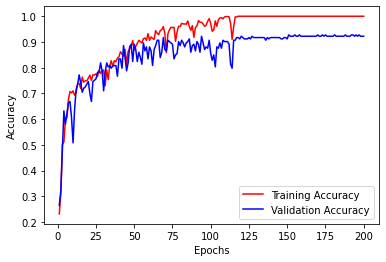

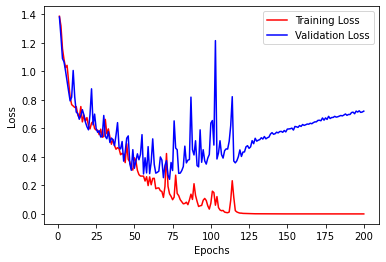

In [8]:
#VISUALISING THE MODEL
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
classifier = tf.keras.models.load_model('/content/drive/MyDrive/Brain Cancer/v3/spark.h5')
evaluation = classifier.evaluate(X_test, Y_test)
print('Loss : ', evaluation[0])
print('Accuracy : ', evaluation[1])

7/7 [==============================] - 1s 50ms/step - loss: 0.5963 - accuracy: 0.9275
Loss :  0.5962518453598022
Accuracy :  0.9274611473083496


In [12]:
# Convert Keras model to TF Lite format.
model = keras.models.load_model('/content/drive/MyDrive/Brain Cancer/v3/spark.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in MBs.
float_model_size = len(tflite_float_model) / (1024*1024)

#Save the TFLite Model
with open("/content/drive/MyDrive/Brain Cancer/v3/spark_TFLite.tflite", "wb") as f:
  f.write(tflite_float_model)
print(f"\n\nWrote TFLite model of {len(tflite_float_model)/(1024*1024)} mb.")

INFO:tensorflow:Assets written to: /tmp/tmp9m19omcn/assets


Wrote TFLite model of 0.5345649719238281 mb.


In [13]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / (1024*1024)
print('Quantized model size = %f mb,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

#Save this Quantized TFLite Model
with open("/content/drive/MyDrive/Brain Cancer/v3/spark_Quantized.tflite", "wb") as f:
  f.write(tflite_quantized_model)
print("Wrote %sTFLite model of %f mb." %
      ("optimized " if tflite_quantized_model else "", len(tflite_quantized_model)/(1024*1024)))

INFO:tensorflow:Assets written to: /tmp/tmpp_55gil4/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_55gil4/assets


Quantized model size = 0.188065 mb,
which is about 35% of the float model size.
Wrote optimized TFLite model of 0.188065 mb.


In [15]:
from tensorflow import keras

#Read the model in
tflite_model = '/content/drive/MyDrive/Brain Cancer/v3/spark_TFLite.tflite'
tflite_model_quantized = '/content/drive/MyDrive/Brain Cancer/v3/spark_Quantized.tflite'

# Initialize TFLite interpreter using the model.
# Load TFLite model and allocate tensors.

#normal
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
#quantized
interpreter_q = tf.lite.Interpreter(model_path=tflite_model_quantized)
interpreter_q.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details_q = interpreter_q.get_input_details()
output_details_q = interpreter_q.get_output_details()
n = 0  #count for accuracy
q = 0
normal = []
quantized = []
# Test model on input data.
for i in range(1, len(X_test)):
  test_image = np.expand_dims(X_test[i], axis=0).astype(np.float32)
  interpreter.set_tensor(input_details[0]['index'], test_image)
  interpreter_q.set_tensor(input_details_q[0]['index'], test_image)
  interpreter.invoke()
  interpreter_q.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  output_data_q = interpreter_q.get_tensor(output_details_q[0]['index'])

  if np.argmax(output_data)==np.argmax(Y_test[i]):
    n+=1
  else:
    normal.append(i)

  if np.argmax(output_data_q)==np.argmax(Y_test[i]):
    q+=1
  else:
    quantized.append(i)
print('\n\nAccuracy of normal model= ', n/len(X_test))
print('\n\nAccuracy of quantized model= ', q/len(X_test))



Accuracy of normal model=  0.9222797927461139


Accuracy of quantized model=  0.9222797927461139


In [16]:
print('Wrongly classified images of normal model :', normal)
print('Wrongly classified images of quantized model :', quantized)

Wrongly classified images of normal model : [28, 41, 49, 50, 62, 72, 89, 110, 116, 129, 130, 137, 149, 163]
Wrongly classified images of quantized model : [28, 35, 41, 49, 50, 62, 72, 110, 116, 129, 130, 137, 149, 163]
